In [17]:
from src.util import DataLoader, AortaNormalizer
from src.visualiazation import plot_pca, plot_random_predictions, plot_relative_error_aorta
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

**Load Data**

In [2]:
data_path = "../../../data/PulHypStudie_Check_npz_v2/"

In [3]:
data_list = [i for i in range(1, 10)]
data_list # pig 10 -> test pig

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [4]:
data_loader = DataLoader(data_path)

X, Y, Pig = data_loader.load_data(data_list)

Data path: ../../../data/PulHypStudie_Check_npz_v2/ contains 10 pigs:
⋅ P_01_PulHyp
⋅ P_02_PulHyp
⋅ P_03_PulHyp
⋅ P_04_PulHyp
⋅ P_05_PulHyp
⋅ P_06_PulHyp
⋅ P_07_PulHyp
⋅ P_08_PulHyp
⋅ P_09_PulHyp
⋅ P_10_PulHyp
Got a list of 9 pigs to load.
To load ['P_01_PulHyp' 'P_02_PulHyp' 'P_03_PulHyp' 'P_04_PulHyp' 'P_05_PulHyp'
 'P_06_PulHyp' 'P_07_PulHyp' 'P_08_PulHyp' 'P_09_PulHyp']
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_01_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_02_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_03_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_04_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_05_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_06_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_07_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_08_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_09_

In [5]:
aorta_normalizer = AortaNormalizer()
Y_norm = aorta_normalizer.normalize_forward(Y)
Y_true = Y[:,:,0]

assert np.allclose(Y_true,aorta_normalizer.normalize_inverse(Y_norm)[:,:,0])

**Load VAE**

In [6]:
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Activation,
    Conv1D,
    ZeroPadding1D,
    Reshape,
    Cropping1D,
)
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            loss, reconstruction_loss, kl_loss = self.vae_loss(
                data, reconstruction, z_mean, z_log_var
            )

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        loss, reconstruction_loss, kl_loss = self.vae_loss(
            data, reconstruction, z_mean, z_log_var
        )

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def vae_loss(self, inputs, outputs, z_mean, z_log_var):
        mse_loss_fn = MeanSquaredError()
        input_dim = 1024
        reconstruction_loss = mse_loss_fn(inputs, outputs) * input_dim
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + self.beta * kl_loss
        return total_loss, reconstruction_loss, kl_loss


# The encoder model
def encoder_model(
    input_shape=(1024, 1),
    channels=(5, 10, 20, 30),
    strides=(4, 4, 4, 4),
    kernel_size=(5, 5, 5, 5),
    latent_dim=8,
):
    encoder_inputs = Input(shape=input_shape)
    x = encoder_inputs

    for ch_n, str_n, kernel_s in zip(channels, strides, kernel_size):
        x = Conv1D(ch_n, kernel_s, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

        x = Conv1D(ch_n, kernel_s, padding="same", strides=str_n)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

    x = Flatten()(x)

    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    z = Sampling()((z_mean, z_log_var))

    return encoder_inputs, z_mean, z_log_var, z


# The decoder model
def decoder_model(
    latent_dim=8,
    channels=(30, 20, 10, 5),
    strides=(4, 4, 4, 4),
    kernel_size=(5, 5, 5, 5),
):
    latent_inputs = Input(shape=(latent_dim,))
    L = (1024 // np.prod(strides)) * channels[0]
    x = Dense(L, activation="elu")(latent_inputs)
    x = Reshape((1024 // np.prod(strides), channels[0]))(x)

    for ch_n, str_n, kernel_s in zip(channels, strides, kernel_size):
        x = Conv1DTranspose(ch_n, kernel_s, padding="same", strides=str_n)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

        x = Conv1D(ch_n, kernel_s, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

    x = Conv1DTranspose(1, 1, activation="elu", padding="same")(x)
    decoded = x

    return latent_inputs, decoded
    
def build_vae_model(hp):
    latent_dim = hp.Int("latent_dim", min_value=4, max_value=16, step=4)
    beta = hp.Float("beta", min_value=0.1, max_value=2.0, step=0.1)
    #num_channels_choice = hp.Choice("num_channels", values=[5, 10, 20, 30])
    kernel_size = hp.Int("kernel_size", min_value=3, max_value=9, step=1)  
    strides = hp.Int("strides", min_value=2, max_value=4, step=1)
        
    channels=(5, 10, 20, 30)
    # kernel_sizes=(5, 5, 5, 5)
    kernel_sizes = [kernel_size] * 4
    # strides=(4, 4, 4, 4)
    stride_sizes = [strides] * 4

    # Build encoder and decoder
    encoder_inputs, z_mean, z_log_var, z = encoder_model(
        channels=channels,
        kernel_size=kernel_sizes,
        strides=stride_sizes,
        latent_dim=latent_dim,
    )
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="Encoder")
    
    decoder_inputs, decoder_outputs = decoder_model(
        channels=channels[::-1],
        kernel_size=kernel_sizes[::-1],
        strides=stride_sizes[::-1],
        latent_dim=latent_dim,
    )
    decoder = Model(decoder_inputs, decoder_outputs, name="Decoder")

    encoder.summary()
    decoder.summary()
    vae = VAE(encoder, decoder, beta=beta)

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("lr", [1e-3, 1e-4, 1e-5])))
    return vae

# Instantiate the tuner
tuner = kt.Hyperband(
    build_vae_model,
    objective="loss",
    max_epochs=20,
    factor=2,
    directory="vae_hpt",
    project_name="vae_tuning_1",
)

2024-12-03 12:32:12.055183: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 12:32:12.660239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Reloading Tuner from vae_hpt/vae_tuning_1/tuner0.json


In [7]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [8]:
vae = tuner.hypermodel.build(best_hps)

2024-12-03 12:32:18.369515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 5)   │         20 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 5)   │         20 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024, 5)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 5)    │         80 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 5)    │         20 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 5)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 256, 10)   │        160 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 10)   │         40 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 64, 10)    │        310 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 10)    │         40 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 10)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 64, 20)    │        620 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 20)    │         80 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 20)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 16, 20)    │      1,220 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 20)    │         80 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 16, 20)    │          0 │ batch_normalizat

 Total params: 9,426 (36.82 KB)

 Trainable params: 9,166 (35.80 KB)

 Non-trainable params: 260 (1.02 KB)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 16, 30)         │         2,730 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 30)         │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 16, 30)         │         2,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 30)         │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 64, 20)         │         1,820 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 64, 20)         │         1,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 256, 10)        │           610 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 256, 10)        │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 11,261 (43.99 KB)

 Trainable params: 11,001 (42.97 KB)

 Non-trainable params: 260 (1.02 KB)

In [9]:
# sel_model = "src/weights/vae_model_excl10_0.weights.h5"
# sel_model = "src/weights/vae_model_excl_none_1.weights.h5"
sel_model = "src/weights/vae_model_excl_10_2.weights.h5"

#vae = vae_model()
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.load_weights(sel_model)
_,_,z = vae.encoder.predict(Y_norm)

/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 146 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1733225543.387592  747824 service.cc:145] XLA service 0x7e948c004a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733225543.387646  747824 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-12-03 12:32:23.404179: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-03 12:32:25.270091: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  96/2298 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

I0000 00:00:1733225546.139810  747824 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2298/2298 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


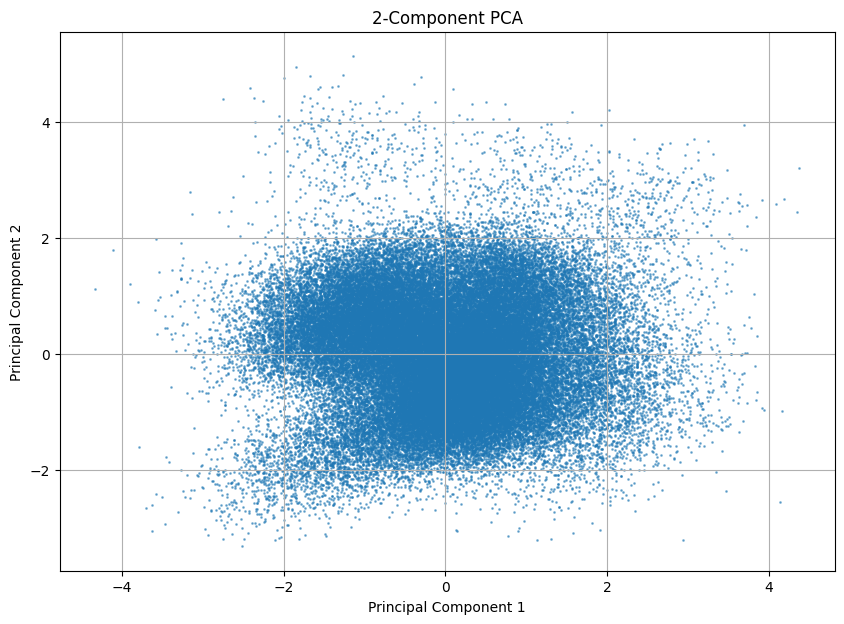

In [18]:
plot_pca(z)

**Train Mapper**

- [KerasTuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [11]:
import keras_tuner as kt
from tensorflow import keras

_HPT with MeanAbsoluteError_

In [12]:
def build_model(hp):
    latent_dim = 8
    # initialize the sequential model.
    model = keras.Sequential()
    # input layer
    model.add(keras.layers.Input(shape=(64, 1024, 1)))
    
    # tune the number of hidden layers and units in each.
    for i in range(1, hp.Int("num_layers", 4, 7)):
        print(f"Init layer {i=}")
        hp_units = hp.Int("units_" + str(i), min_value=2, max_value=16, step=4)
        hp_kernel = hp.Int("kernel_" + str(i), min_value=2, max_value=9, step=1)
        # stride dim (0,1)
        hp_strides_0 = hp.Int("units_0_" + str(i), min_value=1, max_value=4, step=1)
        hp_strides_1 = hp.Int("units_1_" + str(i), min_value=2, max_value=4, step=1)
        hp_activation = hp.Choice("activation_" + str(i), values=['relu','elu','tanh'])
        hp_dropout = hp.Float("dropout_" + str(i), 0, 1.0, step=0.1)
        
        # create layer
        model.add(
            keras.layers.Conv2D(hp_units, hp_kernel, strides=(hp_strides_0, hp_strides_1), padding="same")
        )
        model.add(keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(hp_activation))
        model.add(keras.layers.Dropout(hp_dropout))

    model.add(keras.layers.Flatten())
    # output layer.
    model.add(keras.layers.Dense(latent_dim, activation="linear"))
    
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4,1e-5])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.MeanAbsoluteError(),
                  # loss=keras.losses.MeanSquaredError(),
                  metrics=["accuracy"])
    print(model.summary())

    
    return model

In [13]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hpt_mapper_test10',
    project_name='hpt_mapper_test10'
)


Reloading Tuner from hpt_mapper_test10/hpt_mapper_test10/tuner0.json


In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
tuner.search(X, z, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 85 Complete [00h 07m 35s]
val_accuracy: 0.4407125413417816

Best val_accuracy So Far: 0.5266521573066711
Total elapsed time: 03h 02m 32s

Search: Running Trial #86

Value             |Best Value So Far |Hyperparameter
7                 |4                 |num_layers
10                |2                 |units_1
8                 |6                 |kernel_1
3                 |2                 |units_0_1
2                 |3                 |units_1_1
elu               |tanh              |activation_1
0.1               |0                 |dropout_1
14                |14                |units_2
7                 |6                 |kernel_2
2                 |3                 |units_0_2
3                 |2                 |units_1_2
elu               |elu               |activation_2
0.9               |0.3               |dropout_2
6                 |14                |units_3
7                 |8                 |kernel_3
3                 |4                 |units_0_3
3         

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 22, 512, 10)    │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 22, 512, 10)    │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 22, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 171, 14)    │         6,874 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 171, 14)    │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 11, 171, 14)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 171, 14)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 57, 6)       │         4,122 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 57, 6)       │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 57, 6)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 57, 6)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 29, 10)      │         4,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 29, 10)      │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2, 29, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 29, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 15, 10)      │         3,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 15, 10)      │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 2, 15, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 15, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 4, 10)       │         3,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 4, 10)       │            40 │
│ (BatchNormalization)            │                        │             

 Total params: 24,624 (96.19 KB)

 Trainable params: 24,504 (95.72 KB)

 Non-trainable params: 120 (480.00 B)

None
Epoch 1/50
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.1576 - loss: 0.8200 - val_accuracy: 0.2945 - val_loss: 0.7252
Epoch 2/50
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.2916 - loss: 0.7194 - val_accuracy: 0.3768 - val_loss: 0.6580
Epoch 3/50
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.3525 - loss: 0.6803 - val_accuracy: 0.4007 - val_loss: 0.6230
Epoch 4/50
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.3703 - loss: 0.6689 - val_accuracy: 0.4215 - val_loss: 0.6177
Epoch 5/50
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.3778 - loss: 0.6602 - val_accuracy: 0.4207 - val_loss: 0.6092
Epoch 6/50
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.3876 - loss: 0.6576 - val_accuracy: 0.4349 - val_loss: 0.6017
Epoch 7/50
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.3914 - loss: 0.6516 - val_accuracy: 0.4310 - val_loss: 0.6156
Epoch 8/50
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.3916 - l

In [19]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [20]:
best_hps.values

{'num_layers': 4,
 'units_1': 2,
 'kernel_1': 6,
 'units_0_1': 2,
 'units_1_1': 3,
 'activation_1': 'tanh',
 'dropout_1': 0.0,
 'units_2': 14,
 'kernel_2': 6,
 'units_0_2': 3,
 'units_1_2': 2,
 'activation_2': 'elu',
 'dropout_2': 0.30000000000000004,
 'units_3': 14,
 'kernel_3': 8,
 'units_0_3': 4,
 'units_1_3': 2,
 'activation_3': 'relu',
 'dropout_3': 0.30000000000000004,
 'learning_rate': 0.001,
 'units_4': 2,
 'kernel_4': 3,
 'units_0_4': 3,
 'units_1_4': 2,
 'activation_4': 'relu',
 'dropout_4': 0.30000000000000004,
 'units_5': 10,
 'kernel_5': 3,
 'units_0_5': 4,
 'units_1_5': 4,
 'activation_5': 'relu',
 'dropout_5': 0.9,
 'units_6': 14,
 'kernel_6': 2,
 'units_0_6': 1,
 'units_1_6': 4,
 'activation_6': 'relu',
 'dropout_6': 0.30000000000000004,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0046'}

**Load Best Model**

In [21]:
model = tuner.hypermodel.build(best_hps)

Init layer i=1
Init layer i=2
Init layer i=3


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 342, 2)     │            74 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 342, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 32, 342, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 342, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 171, 14)    │         1,022 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 11, 171, 14)    │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 11, 171, 14)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 11, 171, 14)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 86, 14)      │        12,558 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 3, 86, 14)      │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 3, 86, 14)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3, 86, 14)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3612)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        28,904 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,678 (166.71 KB)

 Trainable params: 42,618 (166.48 KB)

 Non-trainable params: 60 (240.00 B)

None


In [22]:
# es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
history = model.fit(
    X,
    z,
    epochs=100,
    batch_size=16,
    # callbacks=[es],
    validation_split=0.1,
)

Epoch 1/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3466 - loss: 0.7366

I0000 00:00:1733295945.753659  747827 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 128 bytes spill stores, 128 bytes spill loads



4137/4137 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.3466 - loss: 0.7366 - val_accuracy: 0.4966 - val_loss: 0.5564
Epoch 2/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4751 - loss: 0.5830 - val_accuracy: 0.5065 - val_loss: 0.5456
Epoch 3/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.4852 - loss: 0.5698 - val_accuracy: 0.5185 - val_loss: 0.5377
Epoch 4/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.4925 - loss: 0.5635 - val_accuracy: 0.5147 - val_loss: 0.5292
Epoch 5/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.4955 - loss: 0.5572 - val_accuracy: 0.5148 - val_loss: 0.5297
Epoch 6/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.4965 - loss: 0.5552 - val_accuracy: 0.5203 - val_loss: 0.5285
Epoch 7/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.4992 - loss: 0.5524 - val_accuracy: 0.5201 - val_loss: 0.5250
Epoch 8/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5017 - loss: 0.552

In [23]:
model.save_weights("src/weights/mapper_model_6.weights.h5")
np.savez("src/weights/mapper_model_6_history.npz", history=history)

**Test model**

In [24]:
X_test, Y_t, _ = data_loader.load_data(10)

aorta_normalizer = AortaNormalizer()
Y_norm = aorta_normalizer.normalize_forward(Y_t)
Y_true = Y_t[:,:,0]

assert np.allclose(Y_true,aorta_normalizer.normalize_inverse(Y_norm)[:,:,0])

To load ['P_10_PulHyp']
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_10_PulHyp

Aorta curve min=45.03, max=139.87
Eit.shape=(6282, 64, 1024, 1), Y.shape=(6282, 1024, 1)


In [25]:
# predict with trained model
z_pred = model.predict(X_test)
Y_pred = vae.decoder.predict(z_pred)
Y_pred = aorta_normalizer.normalize_inverse(Y_pred)[:,:,0]

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


Pearson correlation coefficient mean 0.9576402976912246
MAE 1053361.8035317531
MSE 66102.47468624945
Pearson number 0.9576402976912246


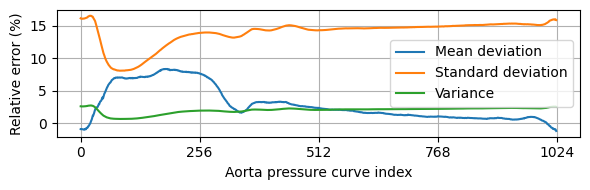

(66102.47468624945, 1053361.8035317531, 0.9576402976912246)

In [26]:
rel_err_config = {
    "std" : True,
    "var" : True,
    "mean" : True,
    "s_name" : "serious_result_1.png",
}

plot_relative_error_aorta(Y_true,Y_pred,**rel_err_config)

Selected prediction 2755.


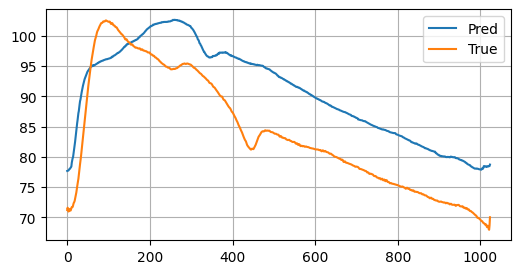

Selected prediction 3548.


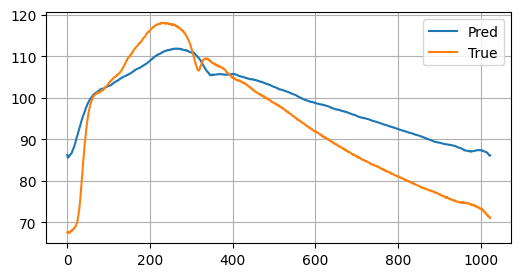

Selected prediction 1551.


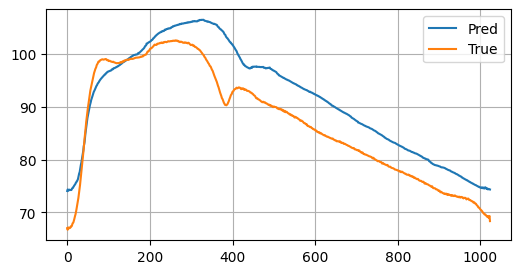

Selected prediction 2908.


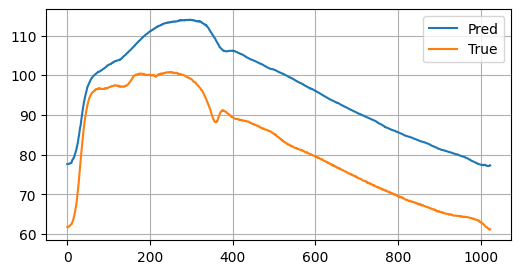

Selected prediction 1543.


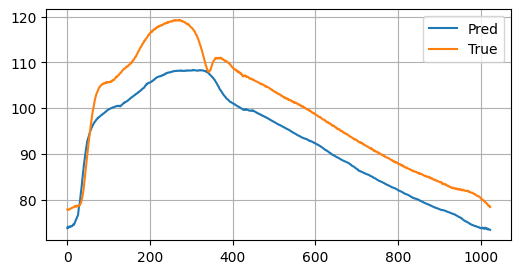

Selected prediction 4814.


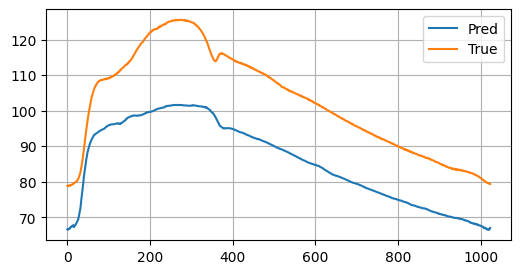

Selected prediction 5791.


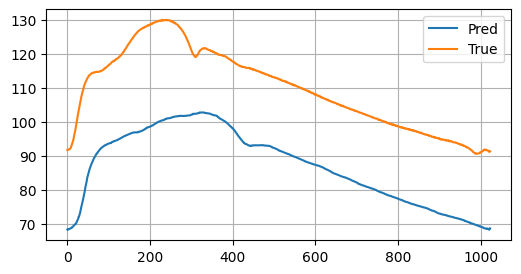

Selected prediction 2941.


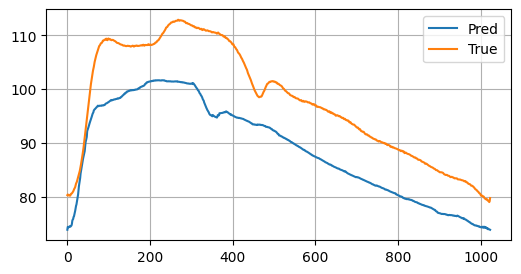

Selected prediction 5103.


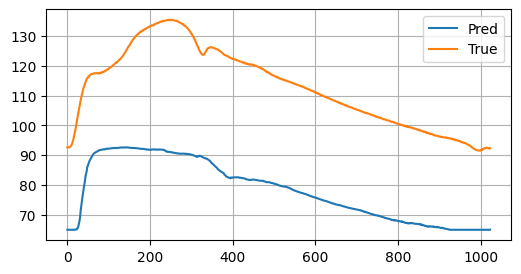

Selected prediction 428.


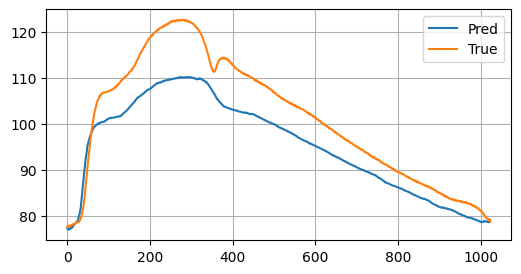

In [40]:
plot_random_predictions(Y_true,Y_pred,n=10)

In [28]:
from src.LaTeX_export import output_err_for_LaTeX,output_curve_for_LaTeX

In [29]:
output_err_for_LaTeX(Y_true, Y_pred,f_name = "err_serious_result_1.csv")

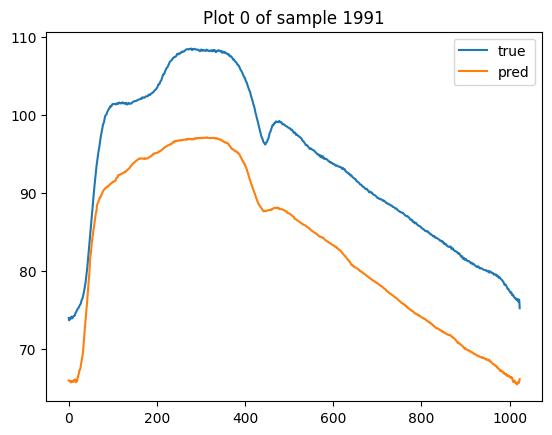

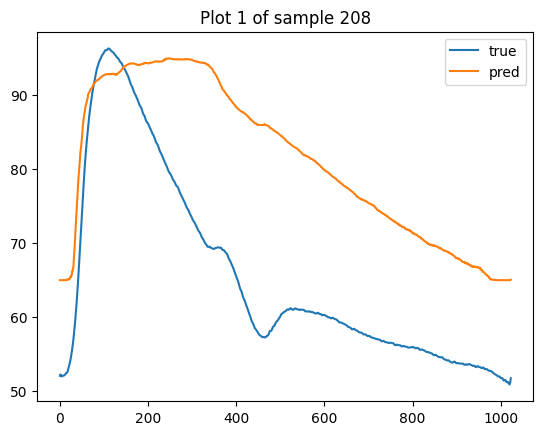

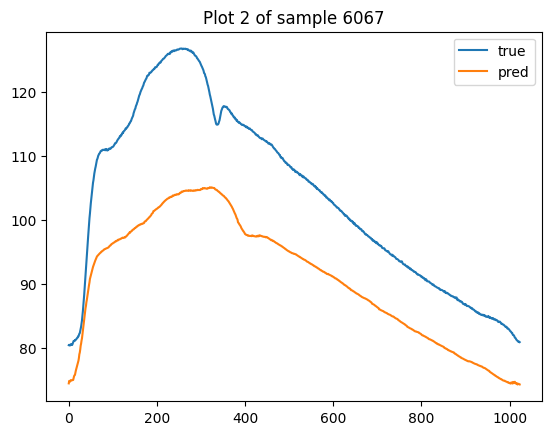

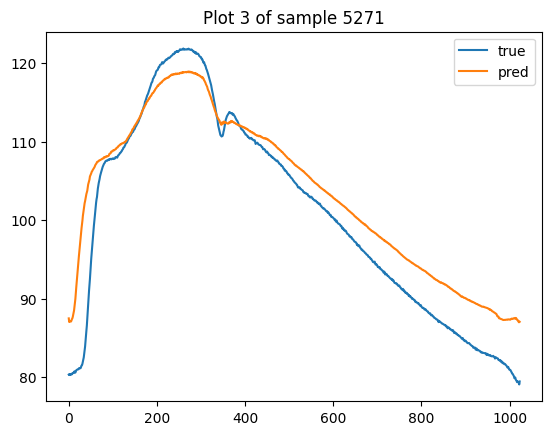

In [30]:
output_curve_for_LaTeX(Y_true, Y_pred,f_name = "curve_serious_result_1.csv")

In [32]:
Y_true.shape

(6282, 1024)

In [34]:
DAP = np.min(Y_true,axis=1)-np.min(Y_pred,axis=1)
SAP = np.max(Y_true,axis=1)-np.max(Y_pred,axis=1)
MAP = np.mean(Y_true,axis=1)-np.mean(Y_pred,axis=1)

In [35]:
import pandas as pd
import seaborn as sns

In [36]:
dd = {"DAP": DAP, "SAP":SAP, "MAP": MAP}
DF = pd.DataFrame(dd)

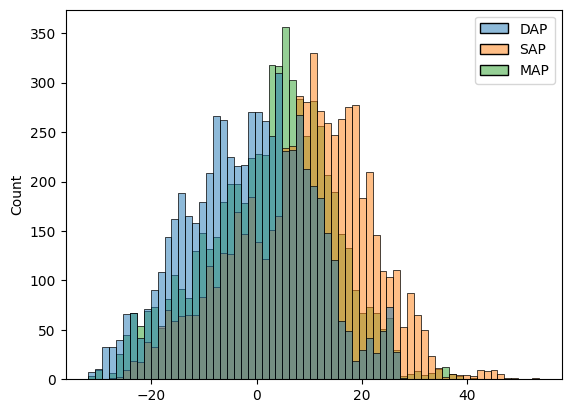

In [37]:
sns.histplot(DF)
plt.savefig("hist_DapSapMap.png")

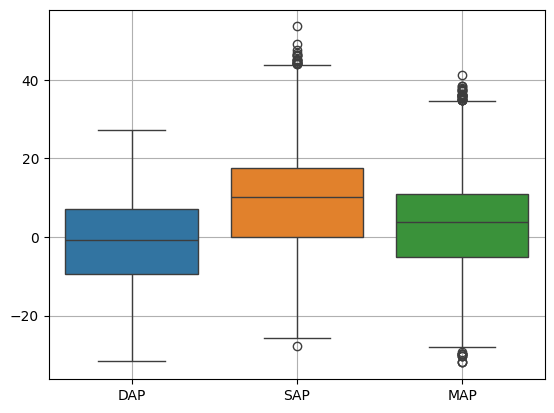

In [39]:
sns.boxplot(DF)
plt.grid()
plt.savefig("box_DapSapMap.png")

**Archive**

*Train Mapper*